In [2]:
!# Install the required libraries
!pip install pandas matplotlib requests

Total Returns: 0.00%
Win Rate: 0.00%
Max Drawdown: 100.00%


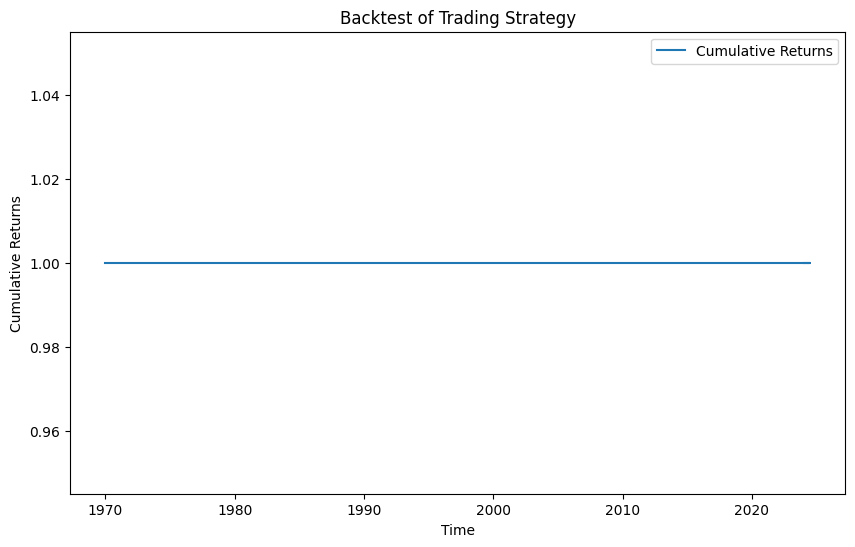

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import requests

# Set the API key
API_KEY = 'o99VpWeTgg4ag2ZEE59nQFgmfIwAkBgH'

# Function to get historical data from Polygon.io
def get_historical_data(symbol, start_date, end_date):
    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/day/{start_date}/{end_date}?adjusted=true&sort=asc&apiKey={API_KEY}"
    response = requests.get(url)
    data = response.json()
    return pd.DataFrame(data['results'])

# Function to determine significant highs and lows
def determine_significant_points(data, window_size=30):
    data['rolling_max'] = data['c'].rolling(window=window_size).max()
    data['rolling_min'] = data['c'].rolling(window=window_size).min()
    data['significant_high'] = data['rolling_max'].shift(1)
    data['significant_low'] = data['rolling_min'].shift(1)
    return data

# Function to simulate the trading strategy
def simulate_strategy(data):
    data['signal'] = 0
    data['position'] = 0
    data['returns'] = 0
    data['cumulative_returns'] = 1
    data['trade'] = None

    for i in range(1, len(data)):
        current_price = data['c'].iloc[i]
        significant_low = data['significant_low'].iloc[i]
        significant_high = data['significant_high'].iloc[i]

        if pd.notna(significant_low) and current_price < significant_low:
            data.at[i, 'signal'] = 1  # Long signal

        elif pd.notna(significant_high) and current_price > significant_high:
            data.at[i, 'signal'] = -1  # Short signal

        # Calculate position based on signal
        if data['signal'].iloc[i] == 1 and data['trade'].iloc[i-1] != 'long':
            # Enter long position
            data.at[i, 'position'] = 1
            data.at[i, 'trade'] = 'long'
        elif data['trade'].iloc[i-1] == 'long':
            # Exit long position at target or stop loss
            entry_price = data['c'].iloc[i-1]
            if current_price >= entry_price * 2 or current_price <= entry_price * 0.6:
                data.at[i, 'position'] = 0
                data.at[i, 'trade'] = 'exit'

        # Calculate returns
        data.at[i, 'returns'] = data['c'].pct_change().iloc[i] * data['position'].iloc[i-1]

        # Calculate cumulative returns
        data.at[i, 'cumulative_returns'] = (1 + data['returns'].iloc[i]) * data['cumulative_returns'].iloc[i-1]

    return data

# Function to evaluate the performance of the strategy
def evaluate_performance(data):
    total_returns = data['cumulative_returns'].iloc[-1] - 1
    num_trades = len(data[data['returns'] != 0])
    if num_trades > 0:
        win_rate = len(data[data['returns'] > 0]) / num_trades
    else:
        win_rate = 0
    max_drawdown = data['cumulative_returns'].min()

    print(f"Total Returns: {total_returns * 100:.2f}%")
    print(f"Win Rate: {win_rate * 100:.2f}%")
    print(f"Max Drawdown: {max_drawdown * 100:.2f}%")

    # Plot cumulative returns
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['cumulative_returns'], label='Cumulative Returns')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.title('Backtest of Trading Strategy')
    plt.show()

# Main execution
if __name__ == "__main__":
    # Fetch historical data
    symbol = 'SPY'
    start_date = '2024-01-01'
    end_date = '2024-06-30'
    data = get_historical_data(symbol, start_date, end_date)

    # Convert timestamp to datetime
    data['t'] = pd.to_datetime(data['t'], unit='ms')
    data.set_index('t', inplace=True)

    # Determine significant points
    data = determine_significant_points(data)

    # Simulate strategy
    results = simulate_strategy(data)

    # Evaluate performance
    evaluate_performance(results)


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, Flatten
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

# Function to get historical data
def get_historical_data(ticker, start_date, end_date):
    return yf.download(ticker, start=start_date, end=end_date)

# Download data
sp500_data = get_historical_data('^GSPC', '2020-01-01', '2024-06-01')
vix_data = get_historical_data('^VIX', '2020-01-01', '2024-06-01')

# Prepare data
data = pd.concat([sp500_data['Close'], vix_data['Close']], axis=1).dropna()
data.columns = ['SP500', 'VIX']
data['Return'] = data['SP500'].pct_change()

# Create sequences of 20 days
def create_sequences(data, seq_length=20):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(data[['SP500', 'VIX']].values)

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
y = np.where(data['Return'][20:].shift(-1) > 0, 1, 0)  # Align y with sequences

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Positional encoding function
def positional_encoding(length, depth):
    depth = depth // 2
    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :] / depth
    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

# Transformer block and model definition
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_transformer_model(input_shape, num_heads=2, ff_dim=32, dropout_rate=0.2, l2_reg=1e-4):
    inputs = Input(shape=input_shape)
    pos_encoding = positional_encoding(input_shape[0], input_shape[1])
    x = inputs + pos_encoding

    transformer_block = TransformerBlock(input_shape[1], num_heads, ff_dim, dropout_rate)
    x = transformer_block(x)
    x = Flatten()(x)
    x = Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    outputs = Dense(1, activation="linear")(x)
    return Model(inputs=inputs, outputs=outputs)


Training with Adam optimizer
Training with RAdam optimizer
Training with NovoGrad optimizer


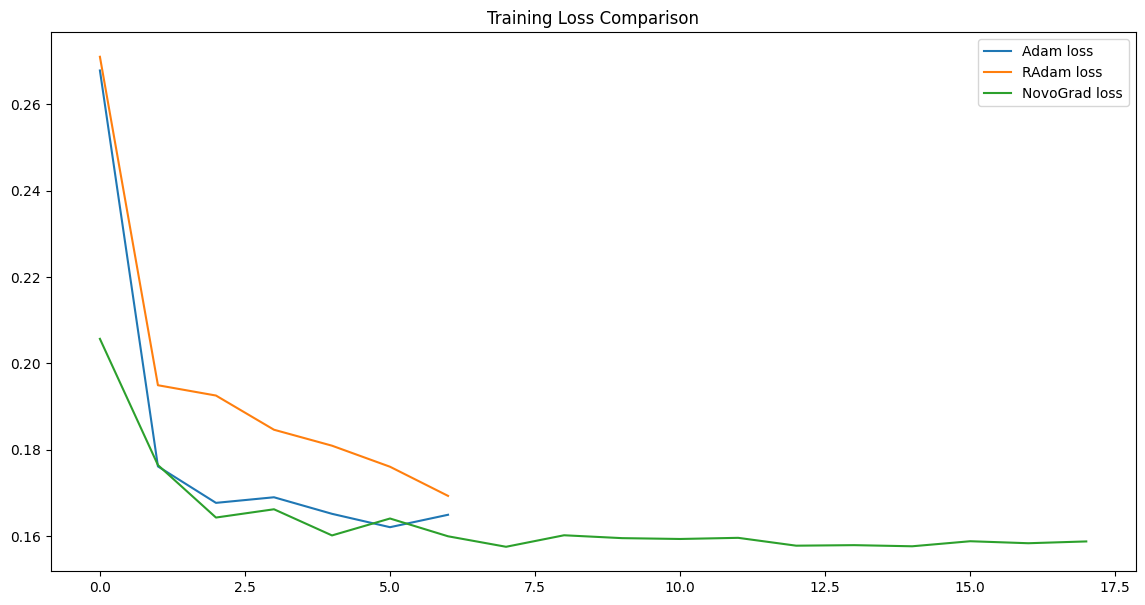

35/35 [==============================] - 0s 4ms/step


ValueError: Length of values (1091) does not match length of index (1071)

In [ ]:
# Learning rate scheduler
def scheduler(epoch, lr):
    return lr * 0.99

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define optimizers
optimizers = {
    'Adam': tf.keras.optimizers.Adam(),
    'RAdam': tfa.optimizers.RectifiedAdam(),
    'NovoGrad': tfa.optimizers.NovoGrad()
}

# Training and evaluation loop
results = {}

for name, optimizer in optimizers.items():
    print(f'Training with {name} optimizer')

    model = build_transformer_model((20, X_train.shape[-1]), num_heads=4, ff_dim=64, dropout_rate=0.3, l2_reg=1e-4)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])

    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, lr_schedule], verbose=0)

    results[name] = history.history

# Plotting the training loss for comparison
plt.figure(figsize=(14, 7))
for name, history in results.items():
    plt.plot(history['loss'], label=f'{name} loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()

# Define mean reversion and momentum strategies
def mean_reversion_strategy(data, window=20):
    data['Mean'] = data['SP500'].rolling(window).mean()
    data['Std'] = data['SP500'].rolling(window).std()
    data['Z-Score'] = (data['SP500'] - data['Mean']) / data['Std']
    data['Signal'] = 0
    data['Signal'] = np.where(data['Z-Score'] > 1, -1, np.where(data['Z-Score'] < -1, 1, 0))
    data['Position'] = data['Signal'].shift()
    data['Strategy_Return'] = data['Position'] * data['SP500'].pct_change()
    return data

def momentum_strategy(data, window=20):
    data['Momentum'] = data['SP500'].pct_change().rolling(window).mean()
    data['Signal'] = 0
    data['Signal'] = np.where(data['Momentum'] > 0, 1, -1)
    data['Position'] = data['Signal'].shift()
    data['Strategy_Return'] = data['Position'] * data['SP500'].pct_change()
    return data

# Predict the strategy to use based on the transformer model
predictions = model.predict(X).flatten()
selected_strategy = np.where(predictions > 0.5, 'momentum', 'mean_reversion')

# Apply the selected strategy
results = []
for i, strategy in enumerate(selected_strategy):
    if strategy == 'momentum':
        strat_result = momentum_strategy(data.iloc[i:i+21].copy())
    else:
        strat_result = mean_reversion_strategy(data.iloc[i:i+21].copy())
    results.append(strat_result['Strategy_Return'].iloc[-1])

# Combine the results
data = data.iloc[20:].copy()  # Align the data to match the sequences
data['Selected_Strategy'] = selected_strategy
data['Strategy_Return'] = results

# Backtest strategy function
def backtest_strategy(data, initial_balance=100000):
    balance = initial_balance
    for i in range(len(data)):
        balance *= (1 + data['Strategy_Return'].iloc[i])
    return balance

# Calculate final balance and Sharpe ratio
final_balance = backtest_strategy(data)
print(f"Final Balance: ${final_balance:.2f}")

returns = data['Strategy_Return']
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


# Adjust buy_hold_returns to match the length of the strategy returns
buy_hold_returns = data['SP500'].iloc[20:].pct_change().fillna(0)
buy_hold_cumulative_returns = (1 + buy_hold_returns).cumprod().reset_index(drop=True)

# Reset index for strategy returns to align both series
strategy_cumulative_returns = strategy_cumulative_returns.reset_index(drop=True)

# Ensure both series are of the same length for plotting
min_length = min(len(buy_hold_cumulative_returns), len(strategy_cumulative_returns))
buy_hold_cumulative_returns = buy_hold_cumulative_returns[:min_length]
strategy_cumulative_returns = strategy_cumulative_returns[:min_length]

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(strategy_cumulative_returns, label='Strategy Returns')
plt.plot(buy_hold_cumulative_returns, label='Buy and Hold Returns')
plt.legend()
plt.title('Strategy vs Buy and Hold Returns')
plt.show()




In [ ]:
# Define mean reversion and momentum strategies
def mean_reversion_strategy(data, window=20):
    data['Mean'] = data['SP500'].rolling(window).mean()
    data['Std'] = data['SP500'].rolling(window).std()
    data['Z-Score'] = (data['SP500'] - data['Mean']) / data['Std']
    data['Signal'] = 0
    data['Signal'] = np.where(data['Z-Score'] > 1, -1, np.where(data['Z-Score'] < -1, 1, 0))
    data['Position'] = data['Signal'].shift()
    data['Strategy_Return'] = data['Position'] * data['SP500'].pct_change()
    return data

def momentum_strategy(data, window=20):
    data['Momentum'] = data['SP500'].pct_change().rolling(window).mean()
    data['Signal'] = 0
    data['Signal'] = np.where(data['Momentum'] > 0, 1, -1)
    data['Position'] = data['Signal'].shift()
    data['Strategy_Return'] = data['Position'] * data['SP500'].pct_change()
    return data

# Predict the strategy to use based on the transformer model
predictions = model.predict(X).flatten()
selected_strategy = np.where(predictions > 0.5, 'momentum', 'mean_reversion')

# Apply the selected strategy
results = []
for i, strategy in enumerate(selected_strategy):
    if strategy == 'momentum':
        strat_result = momentum_strategy(data.iloc[i:i+21].copy())
    else:
        strat_result = mean_reversion_strategy(data.iloc[i:i+21].copy())
    results.append(strat_result['Strategy_Return'].iloc[-1])

# Combine the results
data = data.iloc[20:].copy()  # Align the data to match the sequences
data['Selected_Strategy'] = selected_strategy
data['Strategy_Return'] = results

# Backtest strategy
initial_balance = 100000

def backtest_strategy(data, initial_balance=100000):
    balance = initial_balance
    for i in range(len(data)):
        balance *= (1 + data['Strategy_Return'].iloc[i])
    return balance

final_balance = backtest_strategy(data)
print(f"Final Balance: ${final_balance:.2f}")

# Calculate the Sharpe ratio
returns = data['Strategy_Return']
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(data.index, (1 + data['Strategy_Return']).cumprod(), label='Strategy Returns')
plt.plot(data.index, (1 + data['SP500'].pct_change().iloc[20:


35/35 [==============================] - 0s 6ms/step


Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Strategy_Return'] = data['Position'] * data['SP500'].pct_change()
<ipython-input-28-acef6e2e2ee9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Mean'] = data['SP500'].rolling(window).mean()
<ipython-input-28-acef6e2e2ee9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Std'] = data['SP500'].rollin

ValueError: Length of values (1091) does not match length of index (1111)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Training with Adam optimizer
Training with RAdam optimizer
Training with NovoGrad optimizer


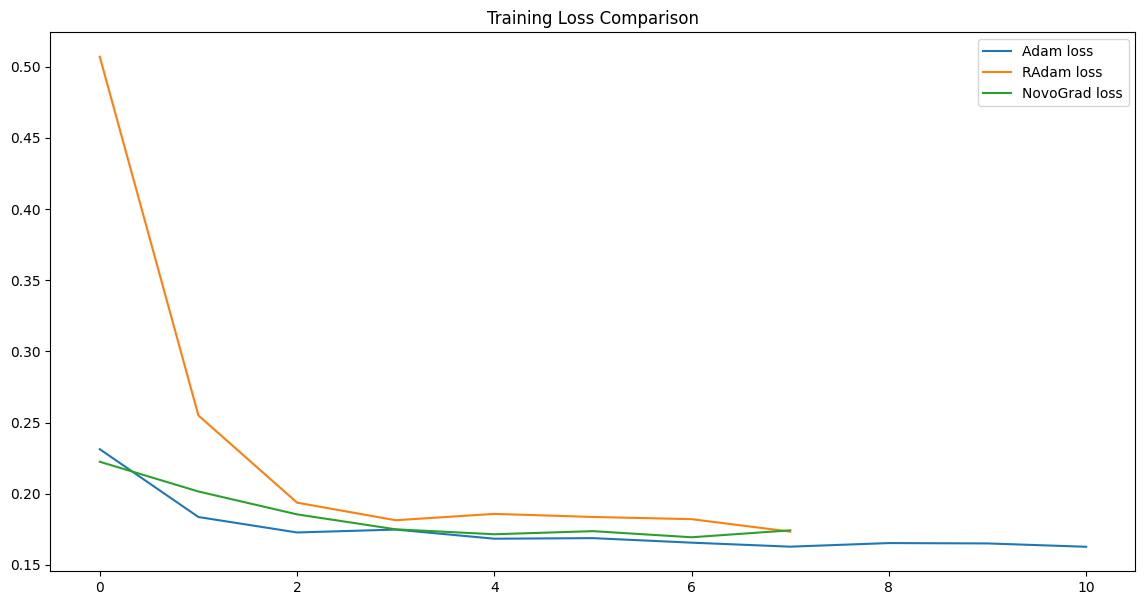

In [ ]:
# Transformer based on https://cs231n.stanford.edu/reports/2022/pdfs/138.pdf


import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.api import VAR
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, Flatten, Embedding
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa

# Define optimizers
optimizers = {
    'Adam': tf.keras.optimizers.Adam(),
    'RAdam': tfa.optimizers.RectifiedAdam(),
    'NovoGrad': tfa.optimizers.NovoGrad()
}

# Function to get historical data
def get_historical_data(ticker, start_date, end_date):
    return yf.download(ticker, start=start_date, end=end_date)

# Download data
sp500_data = get_historical_data('^GSPC', '2020-01-01', '2024-06-01')
vix_data = get_historical_data('^VIX', '2020-01-01', '2024-06-01')

# Prepare data
data = pd.concat([sp500_data['Close'], vix_data['Close']], axis=1).dropna()
data.columns = ['SP500', 'VIX']
data['Return'] = data['SP500'].pct_change()

# Create sequences of 20 days
def create_sequences(data, seq_length=20):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(data[['SP500', 'VIX']].values)

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
y = np.where(data['Return'][20:].shift(-1) > 0, 1, 0)  # Align y with sequences

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Positional encoding function
def positional_encoding(length, depth):
    depth = depth // 2
    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :] / depth
    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

# Transformer block and model definition
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_transformer_model(input_shape, num_heads=2, ff_dim=32, dropout_rate=0.2, l2_reg=1e-4):
    inputs = Input(shape=input_shape)
    pos_encoding = positional_encoding(input_shape[0], input_shape[1])
    x = inputs + pos_encoding

    transformer_block = TransformerBlock(input_shape[1], num_heads, ff_dim, dropout_rate)
    x = transformer_block(x)
    x = Flatten()(x)
    x = Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    outputs = Dense(1, activation="linear")(x)
    return Model(inputs=inputs, outputs=outputs)

# Learning rate scheduler
def scheduler(epoch, lr):
    return lr * 0.99

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training and evaluation loop
results = {}

for name, optimizer in optimizers.items():
    print(f'Training with {name} optimizer')

    model = build_transformer_model((20, X_train.shape[-1]), num_heads=4, ff_dim=64, dropout_rate=0.3, l2_reg=1e-4)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])

    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, lr_schedule], verbose=0)

    results[name] = history.history

# Plotting the training loss for comparison
plt.figure(figsize=(14, 7))
for name, history in results.items():
    plt.plot(history['loss'], label=f'{name} loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()
